In [1]:
import pandas as pd
import joblib as pk
import numpy as np

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sksurv.util import Surv
X_train = pd.read_table("/home/juanrafaelvalera@vhio.org/ondemand/CARE/data/data_train.tsv")
df = X_train


In [2]:

## DATA
# Filtering variables with too many missing values
na_frac = df.drop(columns=["risk_status", "dfs_status", "dfs_time"]).isna().mean()
keep = na_frac[na_frac <= 0.10].index.tolist()
df = df.loc[:, keep + ["risk_status", "dfs_status", "dfs_time"]]

# Removing samples with any missing value
keep = df.drop(columns=["risk_status", "dfs_status", "dfs_time"]).dropna().index.tolist()
df = df.loc[keep, :]

print(f"Training with {df.shape[0]} samples")

y_class = df["risk_status"].copy()
y_event = df["dfs_status"].copy()
y_time = df["dfs_time"].copy()
X = df.drop(columns=["risk_status", "dfs_status", "dfs_time", "os_status"])

# Standard Scale numerical variables
scaler = StandardScaler()
cols = ["edad", "imc", "tamano_tumoral"]
X[cols] = scaler.fit_transform(X[cols])

X_class = X.loc[y_class.notna(), :]
y_class = y_class.loc[y_class.notna()]

X_surv = X.loc[(y_event.notna()) & (y_time.notna()), :]
y_time = y_time.loc[(y_event.notna()) & (y_time.notna())]
y_event = y_event.loc[(y_event.notna()) & (y_time.notna())]
y_surv = Surv.from_arrays(event=y_event.astype(bool), time=y_time)

Training with 121 samples


In [3]:

f ="/home/juanrafaelvalera@vhio.org/ondemand/CARE/artifacts/models/class_logreg.pkl"

with open(f, "rb") as a:
    
    object_file = pk.load(a)
pipe = object_file.best_estimator_ if hasattr(object_file, "best_estimator_") else object_file
pipe.steps


[('scaler', StandardScaler()),
 ('selector', FCBFSelector(kbest=20, mode='rank')),
 ('model',
  LogisticRegression(C=7.196856730011514, l1_ratio=1.0, max_iter=5000,
                     penalty='elasticnet', solver='saga'))]

In [4]:

clf = pipe.named_steps["model"]          # LogisticRegression
coefs = clf.coef_.ravel()                # shape (n_selected,)
intercept = float(clf.intercept_.ravel()[0])

In [7]:
selector = pipe.named_steps["selector"]
X_cols = np.array(X_train.columns)
sels_cols = selector.selected_features_



In [38]:
selected_cols = X_train.columns[sel_cols]


In [43]:
coef_table = (
    pd.DataFrame({
        "feature": selected_cols,
        "coef_log_odds": coefs,
        "odds_ratio": np.exp(coefs),
        "abs_coef": np.abs(coefs),
    })
    .sort_values("abs_coef", ascending=False)
    .drop(columns="abs_coef")
)
top10_lr = coef_table[1:10]



In [65]:

f ="/home/juanrafaelvalera@vhio.org/ondemand/CARE/artifacts/models/class_svc.pkl"

with open(f, "rb") as a:
    
    object_file = pk.load(a)
pipe = object_file.best_estimator_ if hasattr(object_file, "best_estimator_") else object_file
svc = pipe.named_steps["model"]

In [66]:
selected_cols = X_train.columns[pipe.named_steps["selector"].selected_features_]
from sklearn.model_selection import train_test_split

# First split: hold out TEST
X_temp, X_test, y_temp, y_test = train_test_split(
    X_class, y_class, test_size=0.20, stratify=y_class, random_state=0
)

In [67]:

def permutation_importance_table(pipe, X_test, y_test, scoring="roc_auc",
                                 n_repeats=30, random_state=0):
    r = permutation_importance(
        pipe,
        X_test, y_test,
        n_repeats=n_repeats,
        random_state=random_state,
        scoring=scoring,
        n_jobs=-1,
    )
    out = pd.DataFrame({
        "feature": X_test.columns,
        "importance_mean": r.importances_mean,
        "importance_std": r.importances_std,
    }).sort_values("importance_mean", ascending=False)
    return out




In [ ]:

svc_perm = permutation_importance_table(pipe, X_test, y_test, scoring="roc_auc")

In [75]:

f ="/home/juanrafaelvalera@vhio.org/ondemand/CARE/artifacts/models/class_rf.pkl"

with open(f, "rb") as a:
    
    object_file = pk.load(a)
    
pipe = object_file.best_estimator_ if hasattr(object_file, "best_estimator_") else object_file
rf = pipe.named_steps["model"]
selected_cols = X_train.columns[pipe.named_steps["selector"].selected_features_]


In [76]:


rf_mdi = (pd.DataFrame({
    "feature": selected_cols,
    "importance_mdi": rf.feature_importances_,
})
.sort_values("importance_mdi", ascending=False)
.reset_index(drop=True))

rf_mdi.head(10)

,feature,importance_mdi
0,recep_est_porcent,0.214197
1,tipo_histologico_10,0.122356
2,infilt_estr_cervix,0.104148
3,tipo_histologico_88,0.067072
4,tipo_histologico_12,0.058607
5,valor_de_ca125,0.044519
6,tamano_tumoral,0.042236
7,histo_defin_6,0.041588
8,histo_defin_2,0.031830
9,rece_de_Ppor,0.029064


In [83]:

f ="/home/juanrafaelvalera@vhio.org/ondemand/CARE/artifacts/models/class_xgb.pkl"

with open(f, "rb") as a:
    
    object_file = pk.load(a)
    
pipe = object_file.best_estimator_ if hasattr(object_file, "best_estimator_") else object_file

xgb = pipe.named_steps["model"]
selected_cols = list(X_train.columns[pipe.named_steps["selector"].selected_features_])

In [85]:
booster = xgb.get_booster()

# Choose one: "gain" (recommended), "weight", "cover", "total_gain", "total_cover"
importance_type = "gain"

score = booster.get_score(importance_type=importance_type)  # dict like {"f0": ..., "f1": ...}


In [86]:
# Build full vector (including zeros for unused features)
imp = np.zeros(len(selected_cols), dtype=float)
for k, v in score.items():
    if k.startswith("f"):
        idx = int(k[1:])
        if 0 <= idx < len(imp):
            imp[idx] = v

xgb_imp = (pd.DataFrame({
    "feature": selected_cols,
    f"importance_{importance_type}": imp,
})
.sort_values(f"importance_{importance_type}", ascending=False)
.reset_index(drop=True))

xgb_imp.head(20)


,feature,importance_gain
0,infilt_estr_cervix,0.492688
1,valor_de_ca125,0.247722
2,Grado,0.083677
3,edad,0.073432
4,imc,0.068023
5,tipo_histologico_8,0.047044
6,asa_1,0.000000
7,tipo_histologico_3,0.000000
8,asa_2,0.000000
9,histo_defin_8,0.000000


## Feature importance by model

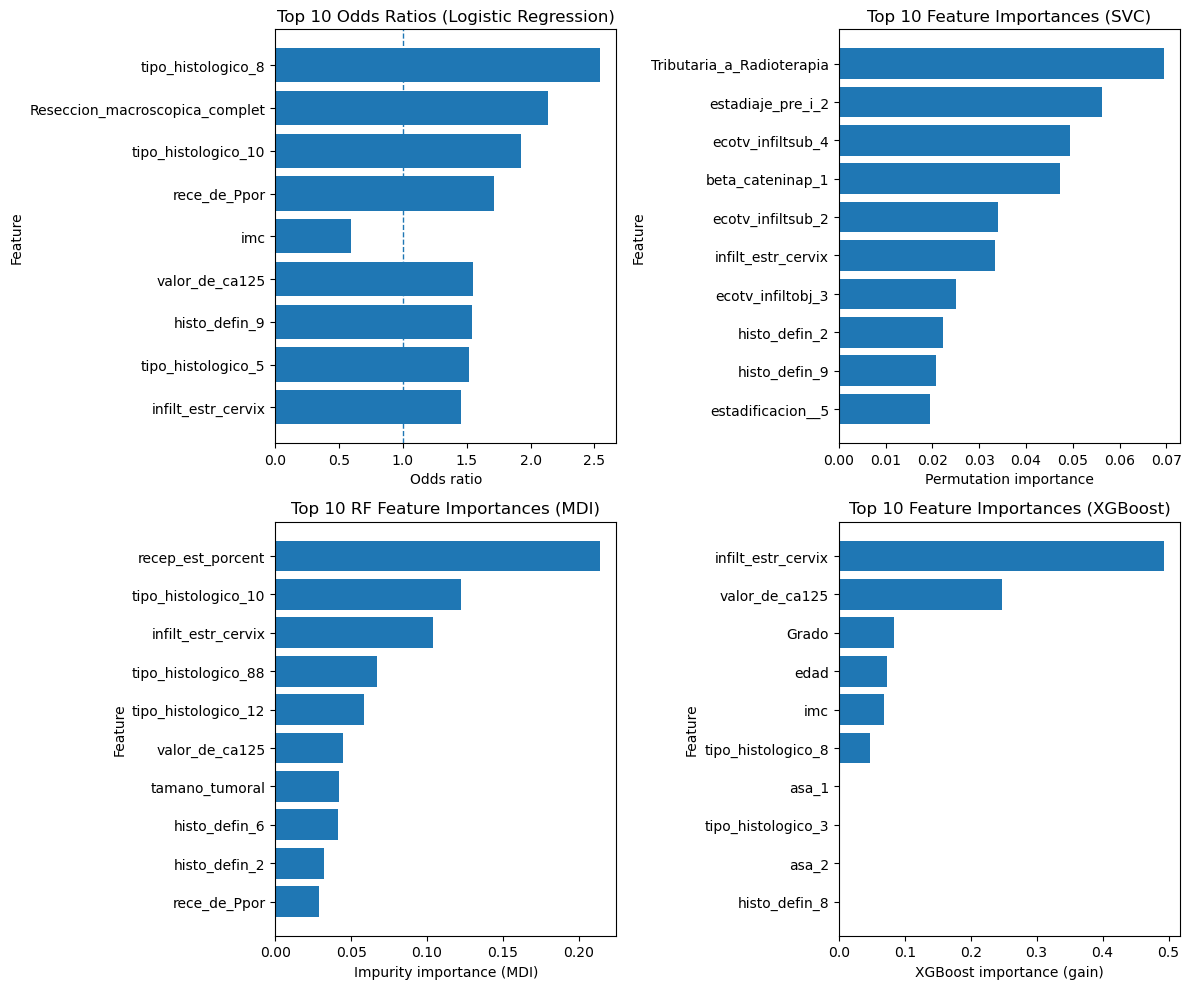

In [92]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# ---- (1) Logistic Regression: Odds Ratios ----
ax = axes[0, 0]
ax.barh(
    top10_lr["feature"][::-1],
    top10_lr["odds_ratio"][::-1],
)
ax.axvline(1, linestyle="--", linewidth=1)
ax.set_xlabel("Odds ratio")
ax.set_ylabel("Feature")
ax.set_title("Top 10 Odds Ratios (Logistic Regression)")

# ---- (2) SVC: Permutation importance ----
top10_sv = svc_perm.head(10)
ax = axes[0, 1]
ax.barh(
    top10_sv["feature"][::-1],
    top10_sv["importance_mean"][::-1],
)
ax.set_xlabel("Permutation importance")
ax.set_ylabel("Feature")
ax.set_title("Top 10 Feature Importances (SVC)")

# ---- (3) Random Forest: Impurity (MDI) ----
top10_rf = rf_mdi.head(10)
ax = axes[1, 0]
ax.barh(
    top10_rf["feature"][::-1],
    top10_rf["importance_mdi"][::-1],
)
ax.set_xlabel("Impurity importance (MDI)")
ax.set_ylabel("Feature")
ax.set_title("Top 10 RF Feature Importances (MDI)")

# ---- (4) XGBoost: Gain (or chosen importance_type) ----
col = f"importance_{importance_type}"
top10_xgb = xgb_imp.head(10)
ax = axes[1, 1]
ax.barh(
    top10_xgb["feature"][::-1],
    top10_xgb[col][::-1],
)
ax.set_xlabel(f"XGBoost importance ({importance_type})")
ax.set_ylabel("Feature")
ax.set_title("Top 10 Feature Importances (XGBoost)")

# ---- Layout ----
fig.tight_layout()
plt.show()



In [105]:
f ="/home/juanrafaelvalera@vhio.org/ondemand/CARE/artifacts/models/risk_coxph.pkl"

with open(f, "rb") as a:
    
    object_file = pk.load(a)

pipe = object_file.best_estimator_ if hasattr(object_file, "best_estimator_") else object_file
cox = pipe.named_steps["model"]


In [109]:
import numpy as np
import pandas as pd

cox = pipe.named_steps["model"]  # CoxPHSurvivalAnalysis

# If your selector stores selected indices (as in your other models)
selected_cols = list(X_train.columns[pipe.named_steps["selector"].selected_features_])

coefs = cox.coef_

if len(selected_cols) != len(coefs):
    raise ValueError(f"selected_cols={len(selected_cols)} but coefs={len(coefs)}; "
                     "you likely have another step that changes feature count (e.g. one-hot encoding).")

coef_table = (pd.DataFrame({
    "feature": selected_cols,
    "coef": coefs,
    "hazard_ratio": np.exp(coefs),
    "abs_coef": np.abs(coefs),
})
.sort_values("abs_coef", ascending=False)
.drop(columns="abs_coef")
.reset_index(drop=True))

coef_table.head(10)


,feature,coef,hazard_ratio
0,infilt_estr_cervix,1.268792,3.556554
1,valor_de_ca125,1.084406,2.957684
2,tipo_histologico_10,1.047439,2.850343
3,tipo_histologico_5,-0.689049,0.502053
4,histo_defin_8,0.440300,1.553174
5,Grado,0.363475,1.438319
6,edad,-0.310813,0.732851
7,imc,-0.228255,0.795922
8,grupo_riesgo_2,0.203159,1.225267
9,AP_centinela_pelvico_4,0.103420,1.108957
